In [540]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [545]:
def getARP(theta):
    return -50+15*np.exp(-theta**2/0.25)+4*np.cos(theta*3)*np.exp(-theta**2/(2*4))

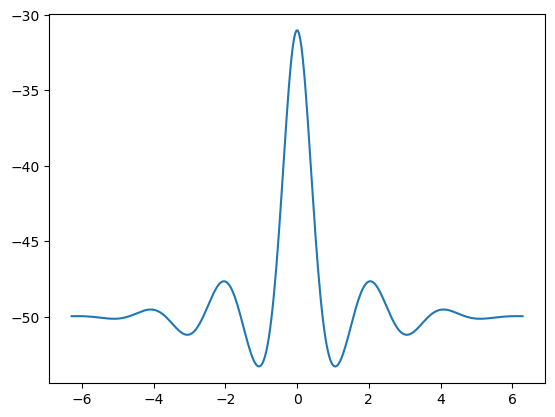

In [544]:
angs = np.linspace(-2*np.pi,2*np.pi,360)
plt.plot(angs,getARP(angs))

In [546]:
np.set_printoptions(precision=3,suppress=True)

In [547]:
def getSample(theta,att,Nsamp=1,gamma=[-0.4,-0.2,0,0.2,0.4]):
    t = getARP(theta+np.array(gamma))
    if np.isscalar(att): att = np.full([Nsamp,1],att)
    if len(att.shape)==1: att = att[:,None]
    f = t[None,:] - att
    y = f+np.random.randn(Nsamp,len(gamma))*2 #std...
    y[f<-95] = np.NaN
    return y

In [548]:
y = getSample(0.5,50,Nsamp=1)[0,:]
y

array([-81.57 , -88.785, -93.13 ,     nan,     nan])

In [577]:
NsampsOftGiveny = 150
NsampsOft = 150


In [578]:
from scipy.stats import norm
angs = np.linspace(-2*np.pi,2*np.pi,360)

pthetaGiveny = []
for i,theta in enumerate(angs):
    print("%d/%d\r"%(i,len(angs)),end="")
    samples = getSample(theta,np.random.randn(NsampsOft)*2,NsampsOft)
    samples = samples-np.mean(samples,1)[:,None]
    samples = np.repeat(samples,NsampsOftGiveny,0)
    samples+=np.random.randn(*samples.shape)*3 #p(t|y) ~ N(y,3^2)

    p_of_ym_given_theta = 0
    for a in np.arange(20,140):
        attenuated_samples = samples-a
        attenuated_samples[attenuated_samples<-95]=np.NaN
        pMissingTrue = np.mean(np.isnan(attenuated_samples),0)
        pm = np.prod(pMissingTrue * np.isnan(y) + (1-pMissingTrue) * ~np.isnan(y))
        #p(y,m|t) = p(y|t)p(m|t)
        py = np.nanprod(np.nanmean(norm(loc=attenuated_samples,scale=2).pdf(y),0))
        p_of_ym_given_theta += pm*py
    pthetaGiveny.append(p_of_ym_given_theta)
pthetaGiveny = np.array(pthetaGiveny)
pthetaGiveny = pthetaGiveny/np.sum(pthetaGiveny)

/tmp/ipykernel_5827/428498172.py:19: RuntimeWarning: Mean of empty slice
  py = np.nanprod(np.nanmean(norm(loc=attenuated_samples,scale=2).pdf(y),0))


In [579]:
from scipy.stats import norm
#angs = np.linspace(-2*np.pi,2*np.pi,100)
Nsamps = 1000
pthetaGiveny_oldmethod = []
ptemp_m = []
ptemp_y = []
#angs = [0.5]

for i,theta in enumerate(angs):
    #print("%d/%d\r"%(i,len(angs)),end="")
    samples = getSample(theta,np.random.randn(Nsamps)*2,Nsamps)
    keep = ~np.isnan(y)
    samples = samples - np.mean(samples[:,keep],1)[:,None]
    samples_obsonly = samples[:,keep]
    ykeep = y[keep]
    ykeep = ykeep - np.mean(ykeep)
    samples_keep = np.nansum((samples_obsonly-ykeep)**2,1)<6**2
    py_givenTheta = np.mean(samples_keep)
    p_missing = norm(samples[samples_keep,:]+np.mean(y[keep]),3).cdf(-95)
    ismissing = np.isnan(y)
    
    pm_givenTheta = np.mean(np.prod(ismissing*p_missing + (~ismissing * (1-p_missing)),1))
    if np.isnan(pm_givenTheta): pm_givenTheta = 0
    pthetaGiveny_oldmethod.append(py_givenTheta*pm_givenTheta)
    ptemp_y.append(py_givenTheta)
    ptemp_m.append(pm_givenTheta)
    #print(theta,py_givenTheta,pm_givenTheta)
pthetaGiveny_oldmethod = np.array(pthetaGiveny_oldmethod)
pthetaGiveny_oldmethod = pthetaGiveny_oldmethod/np.sum(pthetaGiveny_oldmethod)

ptemp_y = np.array(ptemp_y)
ptemp_m = np.array(ptemp_m)
ptemp_y/=np.sum(ptemp_y)
ptemp_m/=np.sum(ptemp_m)

In [614]:
plotyangleExample[np.isnan(y)]

array([63.025, 74.485])

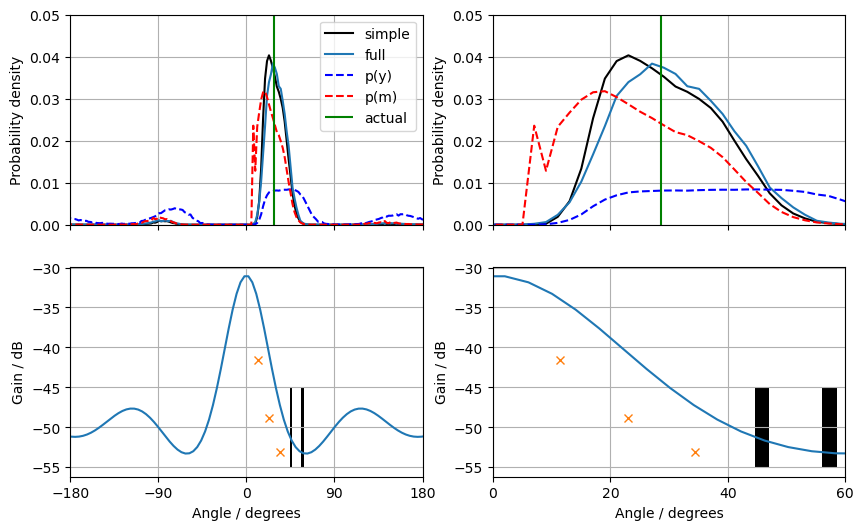

In [634]:
plt.figure(figsize=[10,6])
normalise = 1/(plotangs[1]-plotangs[0])
for plti,xlim in enumerate([[-180,180],[0,60]]):
    plotangs = np.rad2deg(angs)
    plt.subplot(2,2,1+plti)
    plt.plot(plotangs,pthetaGiveny_oldmethod*normalise,'-k',label='simple')
    plt.plot(plotangs,pthetaGiveny*normalise,label='full')
    plt.plot(plotangs,ptemp_y*normalise,'--b',label='p(y)')
    plt.plot(plotangs,ptemp_m*normalise,'--r',label='p(m)')
    plotanswer = np.rad2deg(0.5)
    plt.vlines(plotanswer,0,0.2,color='green',label='actual')
    if plti==0: plt.legend()
    #plt.xlim([0,1])
    plt.xlim(xlim)
    plt.ylim([0,0.05])
    if plti==0:
        plt.xticks(range(-180,181,90),['']*5)
    else:
        plt.xticks(range(0,61,20),['']*4)
    plt.grid()
    plt.ylabel('Probability density')
    
    plt.subplot(2,2,3+plti)
    ARPangs = np.linspace(-2*np.pi,2*np.pi,180)
    plotARPangs = np.rad2deg(ARPangs)
    plt.plot(plotARPangs,getARP(ARPangs))
    plotyangleExample = np.rad2deg(np.array([-0.4,-0.2,0,0.2,0.4])+0.6)
    plt.plot(plotyangleExample,y+40,'x')
    from matplotlib.patches import Rectangle
    ax = plt.gca()
    for a in plotyangleExample[np.isnan(y)]:
        ax.add_patch(Rectangle((a-1.25,-55),2.5,10,fc='black'))
    
    #plt.plot(plotyangleExample[np.isnan(y)],[-55]*sum(np.isnan(y)),'ok')
    plt.xlim(xlim)
    plt.grid()
    if plti==0:
        plt.xticks(range(-180,181,90))
    else:
        plt.xticks(range(0,61,20))
    plt.ylabel('Gain / dB')
    plt.xlabel('Angle / degrees')
plt.savefig('demo_missing_data.pdf')

In [626]:
(plotyangleExample[np.isnan(y)],[-55]*sum(np.isnan(y))),1,10

((array([45.837, 57.296]), [-55, -55]), 1, 10)

In [581]:
y

array([-81.57 , -88.785, -93.13 ,     nan,     nan])